In [ ]:
!pip install -r requirements.txt

In [1]:
# load libraries
import pandas  as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [2]:
# load data from assets folder
path = 'assets/'
train  = pd.read_csv(path + 'train.csv')
test   = pd.read_csv(path + 'test.csv')

In [3]:
# inspect training data
train.head()

,train_id,comment,sentiment
0,bbe0f441-b2fc-461a-9618-e3a7eb9cb6b7,Habari @telecom1_TZ naomba kujua kama kuna hud...,-1
1,81b3b16d-8bf0-4d46-9b68-d7ffb078d108,@telecom3_tanzania Hivi telecom3 mnatuchukulia...,-1
2,f4785623-6bb9-49de-b905-25911a66f1d3,@telecom2 wamupunguza vifurushi vya internet k...,0
3,0ec5ec2b-0811-4b1d-be70-9cc0c137159a,@telecom2 Kwenye huduma1 nimewakubali sana sem...,-1
4,40082169-ebd0-4ca9-b0d3-c46ac949e034,@IdrisSultan vip kuhusu hawa mzee.\n Umefiki...,0


<AxesSubplot:>

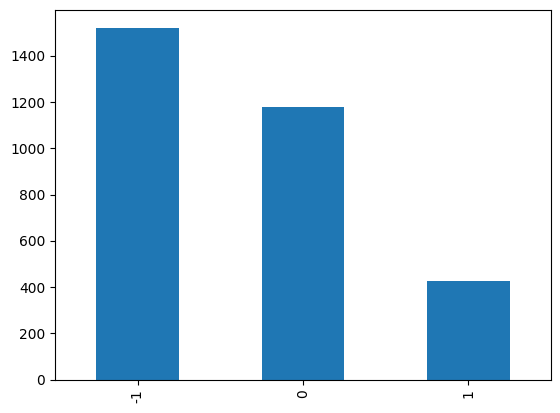

In [4]:
# plot count of sentiments
train.sentiment.value_counts().plot(kind='bar')

In [5]:
# inspect test data
test.head()

,test_id,comment
0,53bb8dff-4a07-4aac-a6f2-ca552389652c,huduma1 wamenitext et wameniona mataa😣
1,a01e1c68-2f77-4073-87c5-d7e5d75c8a79,@telecom1_TZ @telecom3Tanzania Na mtuue sasa
2,9a5e4b98-ac29-4138-bc28-fc878d5d8269,Hakuna mtandao wa simu unaoongoza kutuma messa...
3,9ef55f06-7748-4e02-85c7-fa3e46bb02dd,@Mwanzalimaa Itakuwa kaipenda no yako kaenda k...
4,d93b4084-3000-4026-bae0-ecb65564dbbd,@telecom1_TZ Mm Ni wakala wa usajili wa lain c...


In [6]:
# data cleaning

# Remove duplicate rows
train = train.drop_duplicates()

In [7]:
# Remove rows with missing values
train = train.dropna()

In [8]:
import re

def clean_text(text):
    # Remove special characters, punctuation, and non-Swahili characters
    text = re.sub(r"[^a-zA-Z0-9 \-]", "", text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove HTML tags (if available)
    text = re.sub(r"<.*?>", "", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # remove numbers
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) 
    text = re.sub(r"\d", "", text)
    # set in lowercase
    text = text.lower()   
    
    # Remove consecutive duplicate characters (e.g., 'loooove' to 'love')
    text = re.sub(r"(.)\1+", r"\1", text)
    
    return text

# Apply text cleaning to the 'text' column
train['comment'] = train['comment'].apply(clean_text)

In [9]:
train.head() # preview data again

,train_id,comment,sentiment
0,bbe0f441-b2fc-461a-9618-e3a7eb9cb6b7,habari telecomtz naomba kujua kama kuna huduma...,-1
1,81b3b16d-8bf0-4d46-9b68-d7ffb078d108,telecomtanzania hivi telecom mnatuchukuliaje y...,-1
2,f4785623-6bb9-49de-b905-25911a66f1d3,telecom wamupunguza vifurushi vya internet kim...,0
3,0ec5ec2b-0811-4b1d-be70-9cc0c137159a,telecom kwenye huduma nimewakubali sana sema i...,-1
4,40082169-ebd0-4ca9-b0d3-c46ac949e034,idrisultan vip kuhusu hawa mze umefikia ya mat...,0


In [10]:
train = train.sample(frac=1, random_state=42)

# Split the dataset into train and test sets
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Select 80% of each sentiment class for training
for sentiment in [-1, 0, 1]:
    sentiment_data = train[train['sentiment'] == sentiment]
    n_samples = int(0.8 * len(sentiment_data))
    train_data = train_data.append(sentiment_data[:n_samples])
    test_data = test_data.append(sentiment_data[n_samples:])

# Shuffle the train and test sets again
train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)


C:\Users\Edgar\AppData\Local\Temp\ipykernel_15184\388942368.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(sentiment_data[:n_samples])
C:\Users\Edgar\AppData\Local\Temp\ipykernel_15184\388942368.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(sentiment_data[n_samples:])
C:\Users\Edgar\AppData\Local\Temp\ipykernel_15184\388942368.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(sentiment_data[:n_samples])
C:\Users\Edgar\AppData\Local\Temp\ipykernel_15184\388942368.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_

In [11]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Specify the maximum number of words to be used
max_sequence_length = 64
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(train_data['comment'])

# Convert training texts to sequences of tokens
train_sequences = tokenizer.texts_to_sequences(train_data['comment'])
# Pad training sequences to ensure uniform length
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

# Convert testing texts to sequences of tokens
test_sequences = tokenizer.texts_to_sequences(test_data['comment'])
# Pad testing sequences to ensure uniform length
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)


In [12]:
vocab_size = len(tokenizer.word_index) + 1

test_data.head()

,train_id,comment,sentiment
2327,8e65fcb6-e780-4d55-b9d4-5726101a94b9,telecom kupiga simu na matumizi ya intaneti,0
2690,941c2b47-d6d9-4d8f-b1ab-b857764c94a6,telecomtz mtandao wenu umekua wa kichoko yani ...,0
317,b408f166-dc99-4a44-bef5-71a3ba217c1e,huduma muwe kama m pawa mtu mpaka mtu alipe mw...,-1
1998,bca49ed0-60c6-4d1b-bd56-890be1902e7a,telecomtz simbasctanzania kuliko kununua kwa t...,-1
392,fa754dd2-e25f-48b8-8ed6-ef1d8aea60b1,tulialfreda you know i wil use this against yo...,0


In [13]:
num_classes = 3  # Number of sentiment classes
sentiment_mapping = {-1: 0, 0: 1, 1: 2}

# Convert the sentiment labels to one-hot encoded vectors for training data
train_one_hot_labels = np.zeros((len(train_data), num_classes))
for i, sentiment in enumerate(train_data['sentiment']):
    index = sentiment_mapping[sentiment]
    train_one_hot_labels[i, index] = 1

# Convert the sentiment labels to one-hot encoded vectors for testing data
test_one_hot_labels = np.zeros((len(test_data), num_classes))
for i, sentiment in enumerate(test_data['sentiment']):
    index_ = sentiment_mapping[sentiment]
    test_one_hot_labels[i, index_] = 1


In [14]:
test_padded_sequences.shape, train_padded_sequences.shape, train_one_hot_labels.shape, test_one_hot_labels.shape

((626, 64), (2497, 64), (2497, 3), (626, 3))

In [15]:
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Define the hypermodel
class SentimentAnalysisHyperModel(HyperModel):
    def __init__(self, vocab_size, max_sequence_length, small=False):
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.small = small
    
    def build(self, hp):
        model = Sequential()
        if not self.small:
            model.add(Embedding(self.vocab_size, 136, input_length=self.max_sequence_length))
            model.add(LSTM(128, return_sequences=True))
            model.add(LSTM(102))
            model.add(Dense(hp.Int('layer_units', min_value=96, max_value=128, step=32), activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))
        else:
            model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
            model.add(Bidirectional(LSTM(hp.Int('layer_units', min_value=96, max_value=128, step=32), dropout=0.2, recurrent_dropout=0.2)))
            model.add(Dense(3, activation='softmax'))
            
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(1e-4),
            metrics=['accuracy']
        )
        return model

    def build_model(self, hp=128):
        model = Sequential()
        if not self.small:
            model.add(Embedding(self.vocab_size, 136, input_length=self.max_sequence_length))
            model.add(LSTM(128, return_sequences=True))
            model.add(LSTM(102))
            model.add(Dense(96, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))
        else:
            model.add(Embedding(len(tokenizer.word_index) + 1, 136, input_length=max_sequence_length))
            model.add(LSTM(hp, dropout=0.2, recurrent_dropout=0.2))
            model.add(Dense(3, activation='softmax'))
            
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(1e-4),
            metrics=['accuracy']
        )
        return model




In [16]:
# USE WHEN HYPER PARAMETERS ARE NOT WELL DEFINED

# Define the hyperparameters search space
hypermodel = SentimentAnalysisHyperModel(vocab_size, max_sequence_length, True)
hyperparameters = HyperParameters()
hyperparameters.Int('layer_units', min_value=96, max_value=128, step=32)

# Perform random search hyperparameter tuning
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='swahili_sentiment_analysis_small'
)

tuner.search(train_padded_sequences, train_one_hot_labels, validation_data=(test_padded_sequences, test_one_hot_labels), batch_size=4, epochs=2)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 2 Complete [00h 04m 30s]
val_accuracy: 0.5191693305969238

Best val_accuracy So Far: 0.5399361252784729
Total elapsed time: 00h 09m 59s
INFO:tensorflow:Oracle triggered exit


In [31]:
best_model.layers

In [32]:
history = best_model.fit(train_padded_sequences, train_one_hot_labels, validation_data=(test_padded_sequences, test_one_hot_labels), batch_size=4, epochs=2)

Epoch 1/2
625/625 [==============================] - 185s 283ms/step - loss: 0.9988 - accuracy: 0.4822 - val_loss: 0.9841 - val_accuracy: 0.4872
Epoch 2/2
625/625 [==============================] - 247s 395ms/step - loss: 0.9554 - accuracy: 0.5254 - val_loss: 0.9564 - val_accuracy: 0.5479


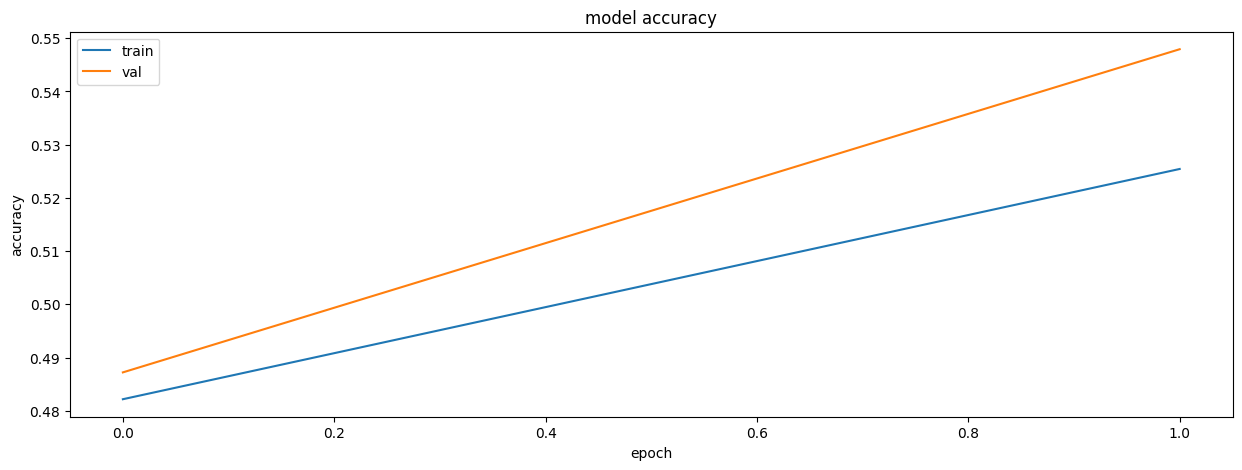

In [33]:
# plot accuracy and loss on training and validation sets
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


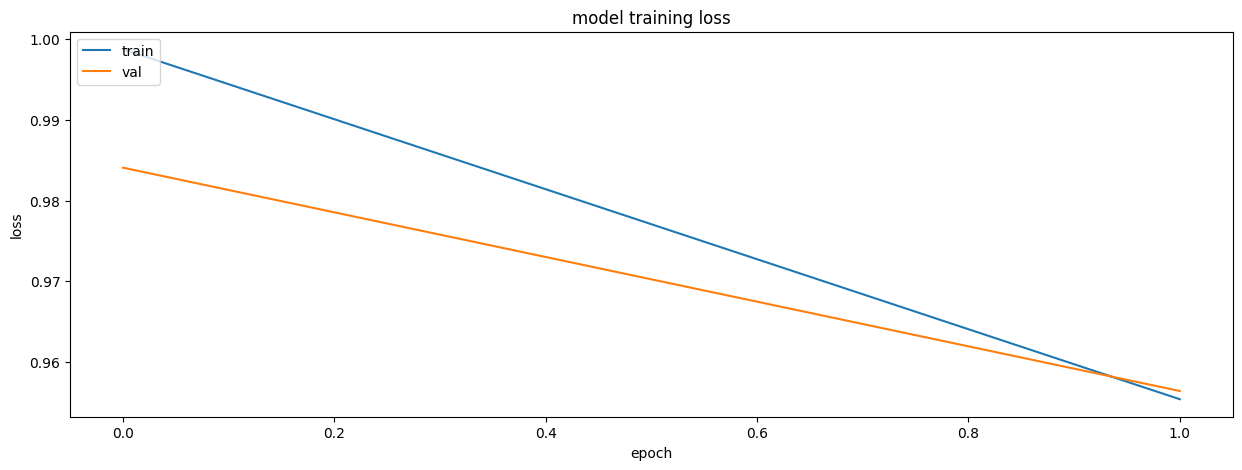

In [42]:
# plot accuracy and loss on training and validation sets
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [34]:
def classify(text, model, tokenizer, max_sequence_length):
    text = clean_text(text)
    # tokenize and pad text
    text_sequences = tokenizer.texts_to_sequences([text])
    # Pad training sequences to ensure uniform length
    text_padded_sequences = pad_sequences(text_sequences, maxlen=max_sequence_length)
    predicted_sentiment = model.predict(text_padded_sequences)

    # Convert the prediction probabilities to sentiment labels
    sentiment_labels = [-1, 0, 1]  
    predicted_result = sentiment_labels[int(np.argmax(predicted_sentiment))]

    # make sure result is returned
    if predicted_result == None or predicted_result not in sentiment_labels:
        print("Could not predict for ", text)
        return classify(text, model, tokenizer, max_sequence_length)

    return int(predicted_result)

In [35]:
msg = "Nilikua sijui kama tozo inaumiza hivi  Leo nimetoa pesa kwa telecom1pesa nimekatwa roho imeniuma kichizðð"
sentiment_result = classify(msg, best_model, tokenizer, max_sequence_length)
sentiment_result

1/1 [==============================] - 2s 2s/step


-1

In [36]:
# save the model
best_model.save("model/hyper_tunned_swahili_sentiment_rating.h5")

#save tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizers/hyper_tunned_swahili_sentiment_rating.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [37]:
test['sentiment'] = test['comment'].apply(lambda x: classify(x, best_model, tokenizer, max_sequence_length))

1/1 [==============================] - 0s 48ms/step


<AxesSubplot:>

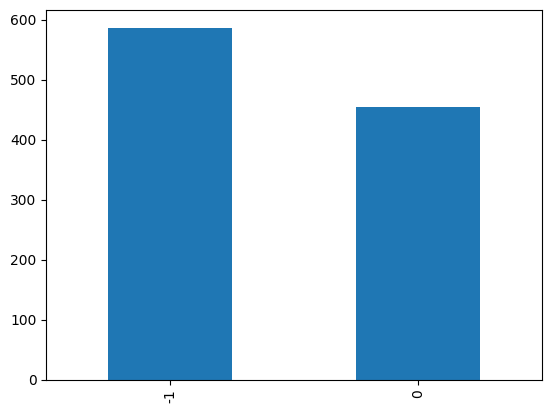

In [38]:
test.sentiment.value_counts().plot(kind='bar')

In [39]:
train_set = pd.read_csv(path + "train.csv")
train_set['predicted_sentiment'] = test['comment'].apply(lambda x: classify(x, best_model, tokenizer, max_sequence_length))

1/1 [==============================] - 0s 208ms/step


<AxesSubplot:>

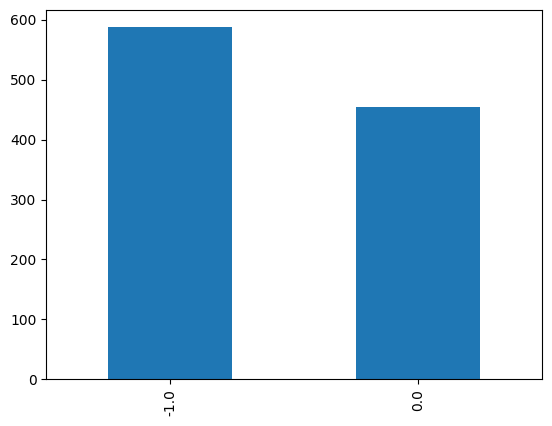

In [40]:
train_set.predicted_sentiment.value_counts().plot(kind='bar')

In [41]:
test.to_csv("results/submission_v2_hyper_tunned.csv", index=False)
train_set.to_csv("results/train_hyper_tunned.csv", index=False)